In [1]:
import numpy as np
import tempfile
import os
import subprocess
import pyslha
from scipy import optimize
import itertools
import time,glob
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
class Parameters(object):
    
    def __init__(self,**kwargs):
        object.__setattr__(self,'parsMapping',{1 : 'M1', 2: 'M2', 3: 'M3', 
                        11: 'At', 12: 'Ab', 13: 'Ata', 
                        23: 'mu', 25: 'tanb', 26: 'mA0', 
                        31: 'meL', 32: 'mmuL', 33: 'mtaL', 34: 'meR', 
                        35: 'mmuR', 36: 'mtaR', 41: 'mq1L', 42: 'mq2L', 43: 'mq3L', 
                        44: 'muR', 45: 'mcR', 46: 'mtR', 47: 'mdR', 48: 'msR', 49: 'mbR'})       
        
        for k,v in kwargs.items():
            setattr(self,k,v)
            
    def __setattr__(self,attr,val):
        if not isinstance(val,Parameter):
            if hasattr(self,attr):
                object.__getattribute__(self,attr).value = val
            else:
                object.__setattr__(self,attr,Parameter(label=attr,value=val))
        else:
            object.__setattr__(self,attr,val)
            
    def getEXTPARDict(self):
        
        blockDict = {0: -1}
        for k,attr in self.parsMapping.items():
            
            blockDict[k] = getattr(self,attr).value
        return blockDict
        
class Parameter(object):
    
    def __init__(self,label=None,value=None):
        self.value = value
        self.label = label
        
    def __str__(self):
        return '%s = %s' %(self.label,self.value)
    
    def __repr__(self):
        return str(self)

In [3]:
def runSoftSusy(blockDict,inputFile=None,outputFile=None,removeInput=True):
    if not inputFile:
        fInput,inputFile = tempfile.mkstemp(suffix='.in',dir='./',prefix='pars_')
        os.close(fInput)
    with open(inputFile,'w') as f:
        for block in blockDict:
            f.write('BLOCK %s \n' %block.upper())
            for key,val in sorted(blockDict[block].items()):
                f.write('  %i   %1.5e\n' %(key,val))       
    try:
        output = subprocess.check_output('./softpoint.x leshouches < %s' %inputFile, shell=True, text=True,
                                    stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError as e:
        output = e.output
    if not outputFile:
        outputFile = inputFile.replace('.in','.out')
    with open(outputFile,'w') as f:
        f.write(output)
    if removeInput:
        os.remove(inputFile)
    return outputFile

In [4]:
def getmHDiff(At,softPars):
    softPars.At = At
    blocks['EXTPAR'] = softPars.getEXTPARDict()
    out = runSoftSusy(blocks)
    r = pyslha.readSLHAFile(out)
    mH = r.blocks['MASS'][25]
    os.remove(out)
    return abs(mH-125.0)


def getErrors(slhafile):
    errors = {}
    with open(slhafile,'r') as fdata:
        data = fdata.read()
        data = data[data.find('Block SPINFO'):data.find('Block MODSEL')]
        data = data.splitlines()
        for l in data[1:]:
            if l.startswith('#'):
                continue
            l = l[:l.find('#')]
            i,v = l.split(maxsplit=1)[:2]
            if eval(i) > 2:
                msg = v.strip()
                errors[i] = msg
    return errors


def checkGoodPoint(At,softPars):

    softPars.At = At
    blocks['EXTPAR'] = softPars.getEXTPARDict()
    out = runSoftSusy(blocks)
    errorsDict = getErrors(out)
    if errorsDict:
        return -1
    else:
        return 1

In [5]:
blocks = {}
blocks['MODSEL'] = {1: 0 }# (0 = MSSM)
blocks['SMINPUTS'] = {1: 1.279340000e+02, # alpha^(-1) SM MSbar(MZ)
                     2 : 1.166370000e-05, # G_Fermi
                     3: 1.172000000e-01, # alpha_s(MZ) SM MSbar
                     4: 9.118760000e+01, # MZ(pole)
                     5: 4.250000000e+00, # mb(mb) SM MSbar
                     6: 1.743000000e+02, # mtop(pole)
                     7: 1.777000000e+00} # mtau(pole)

blocks['SOFTSUSY'] = {0: 1, # Calculate decays in output (only for RPC (N)MSSM)
                     1: 1e-3, # Numerical precision: suggested range 10^(-3...-6)
                     2: 0, # Quark mixing parameter: see manual
                     3: 0, # Additional verbose output?
                     4: 1, # Change electroweak symmetry breaking scale?
                     5: 1, # Include 2-loop scalar mass squared/trilinear RGEs
                     6: 1e-4, # Numerical precision
                     7: 2, # Number of loops in Higgs mass computation
                     10: 0, # Force it to SLHA***1*** output?
                     11: 1e19, # Gravitino mass
                     12: 1, # Print spectrum even when point disallowed
                     13: 0} # Set a tachyonic A^0 to zero mass

In [6]:
softPars = Parameters()
softPars.mHeavy = 5e3
softPars.mLight = 5e2

In [7]:
softPars.M2 = softPars.mHeavy  #Wino mass
softPars.mA0 = softPars.mHeavy
softPars.meL = softPars.mmuL = softPars.mtaL = softPars.mHeavy
softPars.meR = softPars.mmuR = softPars.mtaR = softPars.mHeavy
softPars.mq1L = softPars.mq2L = softPars.mHeavy
softPars.muR = softPars.mcR = softPars.mdR = softPars.msR = softPars.mbR = softPars.mHeavy
softPars.mu = softPars.mHeavy
softPars.Ata = 0. #Tau trilinear

softPars.tanb = 30.
softPars.M1 = 100.
softPars.M3 = 1e3
softPars.mtR = 500.
softPars.mq3L = 500.
softPars.At = 2*np.sqrt(softPars.mq3L.value*softPars.mtR.value)
softPars.Ab = softPars.At

In [8]:
M1list = np.linspace(10.,800.,15)
M3list = np.linspace(2000.,2000.,1)
mtRlist = np.linspace(200.,2000.,20)
mq3Llist = np.linspace(200.,2000.,20)

In [9]:
nfile = 0
t0 = time.time()
for pt in itertools.product(M1list,M3list,mtRlist,mq3Llist):
    if min(pt) != pt[0]:
        continue
    softPars.M1 = pt[0]
    softPars.M3 = pt[1]
    softPars.mtR = pt[2]
    softPars.mq3L = pt[3]
    softPars.At = 2*np.sqrt(softPars.mq3L.value*softPars.mtR.value)
    softPars.Ab = softPars.At
    blocks['EXTPAR'] = softPars.getEXTPARDict()
    out = runSoftSusy(blocks,outputFile='scan_%i.slha'%nfile)
    nfile += 1
print('Done in %1.3f min' %((time.time()-t0)/60.))

KeyboardInterrupt: 

In [10]:
errors = {}
for f in glob.glob('scan_results/scan*slha'):
    errorDict = getErrors(f)
    for msg in errorDict.values():
        if not msg in errors:
            errors[msg] = [os.path.basename(f)]
        else:
            errors[msg].append(os.path.basename(f))

In [11]:
ntotal = []
for k in errors.keys():
    print(k,len(errors[k]))
    ntotal += errors[k]
ntotal = list(set(ntotal))
print('Total=',len(set(ntotal)))

[ stop tachyon ] 1042
stop LSP 1275
sbottom LSP 481
[ sbottom tachyon ] 2122
Possible problem: Not achieved desired accuracy of 1.00000000e-03- got 1.45828146e-02 1
[ No convergence sbottom tachyon ] 4
Possible problem: Not achieved desired accuracy of 1.00000000e-03- got 1.59834466e-02 1
[ hpm tachyon ] 4
Possible problem: Not achieved desired accuracy of 1.00000000e-03- got 1.40423259e-02 1
Possible problem: Not achieved desired accuracy of 1.00000000e-03- got 1.52170842e-02 1
Total= 3652


In [12]:
goodF = []
for f in glob.glob('scan_results/scan*slha'):
    if not os.path.basename(f) in ntotal:
        goodF.append(os.path.basename(f))
print(len(goodF))

2037


In [13]:
softPars = Parameters()
for f in goodF:
    if os.path.isfile('./new_scan_results/new_'+f):
        continue
    r = pyslha.readSLHAFile('./scan_results/'+f)
    #Do not optimize if difference is below 1 GeV
    if abs(r.blocks['MASS'][25]-125.) < 1.:
        shutil.copy('./scan_results/'+f,'./new_scan_results/new_'+f)
        continue
    for ipar,val in r.blocks['EXTPAR'].items():
        if ipar in softPars.parsMapping:
            par = softPars.parsMapping[ipar]
            setattr(softPars,par,val)            
    Atbest = optimize.minimize(getmHDiff,x0=softPars.At.value,
                              method='COBYLA',tol=0.1,args=softPars,
                           options={'rhobeg': 0.1*softPars.At.value, 'tol' : 1e-1},
                          constraints={'type' : 'ineq', 
                                       'fun' : checkGoodPoint, 'args' : (softPars,)})         
    softPars.At = Atbest.x
    blocks['EXTPAR'] = softPars.getEXTPARDict()
    out = runSoftSusy(blocks,outputFile='./new_scan_results/new_'+f)
    if getErrors(out):
        os.remove('./new_scan_results/new_'+f)
        shutil.copy('./scan_results/'+f,'./new_scan_results/new_'+f)

In [14]:
mHnew = []
mHold = []
for f in glob.glob('new_scan_results/*slha'):
    mHnew.append(pyslha.readSLHAFile(f).blocks['MASS'][25])
    mHold.append(pyslha.readSLHAFile('./scan_results/'+os.path.basename(f).replace('new_','')).blocks['MASS'][25])
#     if mHnew[-1] < 100.:
#         print(f)
#         print(mHnew[-1],mHold[-1])
#         break

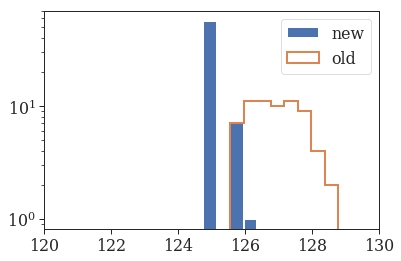

In [17]:
bins = np.linspace(90.,130.,100)
plt.hist(mHnew,bins=bins,label='new',histtype='bar',linewidth=2)
plt.hist(mHold,bins=bins,label='old',histtype='step',linewidth=2)
plt.legend()
plt.xlim(120.,130.)
plt.yscale('log')
plt.show()